In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#train and test dataset path
train_data_file = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_file = '/kaggle/input/brain-tumor-mri-dataset/Testing'


In [4]:
#set data transformers
target_size = (150, 150)

train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(target_size, antialias = True),
    transforms.ColorJitter(brightness = (0.85, 1.15)),
    transforms.RandomAffine(degrees = 0, translate = (0.002, 0.002)),
    transforms.RandomRotation(degrees = 10),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transformer = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Resize(target_size, antialias = True),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [5]:
#load data
train_data = ImageFolder(train_data_file, transform= train_transformer)
train_dataload = DataLoader(train_data, batch_size= 34, shuffle= True)

test_data = ImageFolder(test_data_file, transform= test_transformer)
test_dataload = DataLoader(test_data, batch_size= 34, shuffle= True)

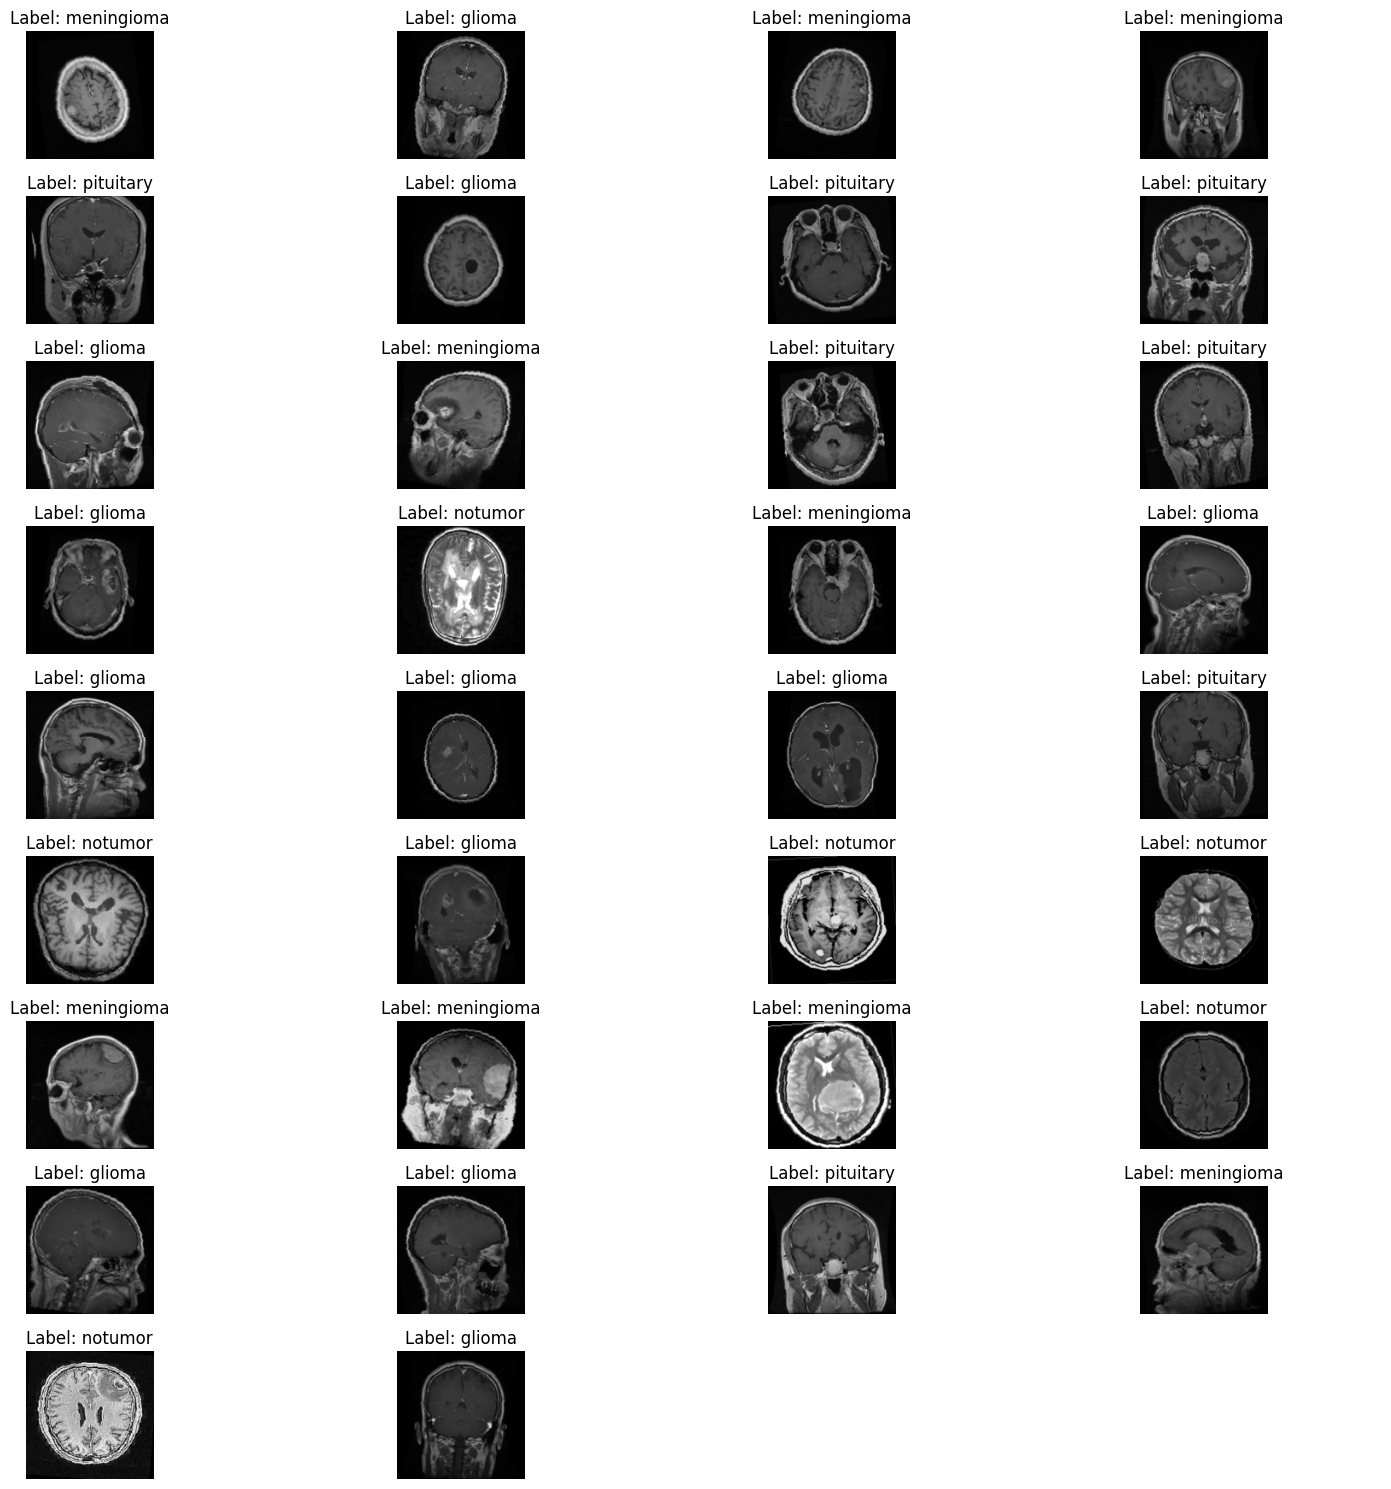

In [6]:
#plot dataset images

images, labels = next(iter(train_dataload))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))


for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_data.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
#create model class

class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size=3),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size=3),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size=3)
        )
        
        self.flatten = nn.Flatten()
        
        self.dense_layers = nn.Sequential(
            nn.Linear(128 * 5 * 5, 512),
            nn.ReLU(inplace= False),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        x = self.dense_layers(x)
        return x
        

In [8]:
model = BrainTumorClassifier(num_classes= len(train_data.classes)).to(device)
print(model)

BrainTumorClassifier(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)
model_rlr = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.3, patience = 2, verbose = True)

In [10]:
epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [11]:
#function for accuracy
def accuracy(x, y):
    correct = torch.eq(x, y).sum().item()
    accuracy = (correct / len(y))
    return accuracy

In [12]:
#training loop

for epoch in range(epochs):
    train_loss = 0.0 
    train_acc = 0.0
    
    model.train()
    
    for i , (inputs, labels) in enumerate(train_dataload):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _,predictions = torch.max(outputs, 1)
        train_loss += loss.item()
        train_acc += accuracy(predictions, labels)
    
    train_acc /= len(train_dataload)
    train_accuracies.append(train_acc)
    
    train_loss /= len(train_dataload)
    train_losses.append(train_loss)
    
    test_loss = 0.0 
    test_acc = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_dataload:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            _,predictions = torch.max(outputs, 1)
            test_loss += loss.item()
            test_acc += accuracy(predictions, labels)
            
        test_acc /= len(test_dataload)
        test_accuracies.append(test_acc)
        
        test_loss /= len(test_dataload)
        test_losses.append(test_loss)
        
        lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch + 1}/{epochs} | Learning Rate: {lr}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_acc:.4f}')
            
    

Epoch 1/20 | Learning Rate: 0.001
Train Loss: 0.8498, Train Accuracy: 0.6371
Val Loss: 0.5901, Val Accuracy: 0.7623
Epoch 2/20 | Learning Rate: 0.001
Train Loss: 0.4595, Train Accuracy: 0.8281
Val Loss: 0.4740, Val Accuracy: 0.8086
Epoch 3/20 | Learning Rate: 0.001
Train Loss: 0.3506, Train Accuracy: 0.8687
Val Loss: 0.2910, Val Accuracy: 0.8972
Epoch 4/20 | Learning Rate: 0.001
Train Loss: 0.2613, Train Accuracy: 0.9042
Val Loss: 0.2217, Val Accuracy: 0.9159
Epoch 5/20 | Learning Rate: 0.001
Train Loss: 0.2036, Train Accuracy: 0.9231
Val Loss: 0.2625, Val Accuracy: 0.9092
Epoch 6/20 | Learning Rate: 0.001
Train Loss: 0.1823, Train Accuracy: 0.9319
Val Loss: 0.1505, Val Accuracy: 0.9453
Epoch 7/20 | Learning Rate: 0.001
Train Loss: 0.1544, Train Accuracy: 0.9443
Val Loss: 0.1858, Val Accuracy: 0.9329
Epoch 8/20 | Learning Rate: 0.001
Train Loss: 0.1239, Train Accuracy: 0.9571
Val Loss: 0.1907, Val Accuracy: 0.9270
Epoch 9/20 | Learning Rate: 0.001
Train Loss: 0.1128, Train Accuracy: 0.

In [13]:
#evaluate model
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_dataload:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
            
        _,predictions = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        
    print(f'Test Accuracy Score: {accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))*100:.2f} %')

Test Accuracy Score: 97.86 %


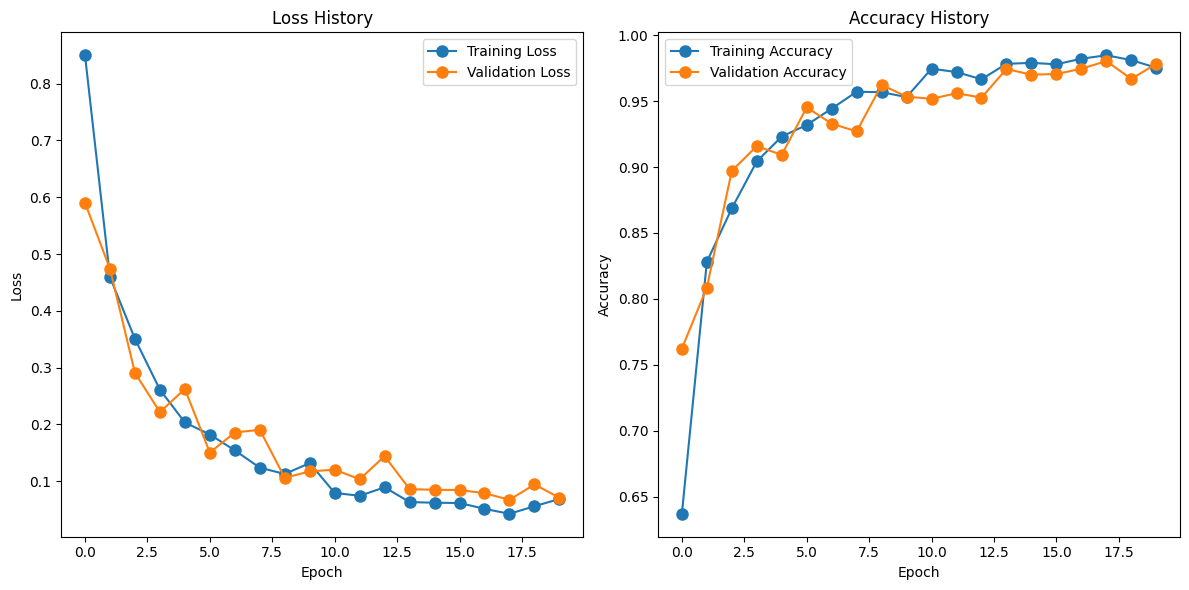

In [14]:

#plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker = 'o', label='Training Loss', markersize= 8)
plt.plot(test_losses, marker = 'o', label='Validation Loss',markersize= 8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

#plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker = 'o', label='Training Accuracy', markersize= 8)
plt.plot(test_accuracies,marker = 'o', label='Validation Accuracy', markersize= 8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()